In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 27 14:19:46 2022

@author: NAGAR
"""

# Modules
################################################################################
import pandas as pd
import psutil
from pandas import HDFStore
import os
import time
from unidecode import unidecode
import datetime
import io
import gc
import glob
import re
import numpy as np
from scipy.sparse import csr_matrix

import time

from multiprocessing import Pool
import multiprocessing
multiprocessing.cpu_count()

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()
import gc

from zipfile import ZipFile
from io import BytesIO


from linearmodels import PanelOLS
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.panel import compare
np.random.seed(22)

import dask
print("Dask Version : {}".format(dask.__version__))



import seaborn as sns
import matplotlib.pyplot as plt

Dask Version : 2024.8.2


In [2]:
SourceDir = "C:/Users/jayho/OneDrive - Duke University/"


# Reliance on Science
data_ros = r"C:\Users\jayho\OneDrive - Duke University\GrantsLLM\Data\ROS"


# EPO data 
patstat = r"C:\Users\jayho\Documents\patstat2024"


ABF=r"C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research\Data"

marxfuegi = r"C:\Users\jayho\OneDrive - Duke University\ERC\marxfuegi"

# OpenAlex

openalex = r"C:\Users\jayho\OneDrive - Duke University\nscipat\OpenAlex"

In [3]:
input_file = 'tls201_appln.parquet'
input_data = os.path.join(patstat, input_file)

In [4]:
tls201_var = ['appln_id','docdb_family_id','inpadoc_family_id','earliest_filing_year','appln_auth']
df_pat = pd.read_parquet(input_data, engine='pyarrow', columns=tls201_var)

In [5]:
df_pat = df_pat[df_pat['appln_auth']=="US"]

In [6]:
OECD_file = os.path.join(ABF, "OECD\\202401_OECD_PATENT_QUALITY_USPTO_INDIC.txt")
print(OECD_file)

OECD= pd.read_csv(OECD_file, sep='|',on_bad_lines='skip')

C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research\Data\OECD\202401_OECD_PATENT_QUALITY_USPTO_INDIC.txt


In [7]:
OECD[(OECD['appln_id']==341894545)|(OECD['appln_id']==341894650)|(OECD['appln_id']==341894651)
    |(OECD['appln_id']==341894682)]

,appln_id,pub_nbr,filing,tech_field,many_field,patent_scope,family_size,grant_lag,bwd_cits,npl_cits,...,claims_bwd,fwd_cits5,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6
4547211,341894682,US08621271,2011,6,0,1,2,879.0,90,19,...,NaN,61,133,0,0.444006,0.927394,0.447802,5.0,0.269677,0.415689
4687437,341894651,US08762793,2011,6,0,1,2,1054.0,87,17,...,NaN,61,133,0,0.444006,0.925635,0.456395,6.0,0.325799,0.438772
4827507,341894650,US08904226,2011,6,0,1,2,1215.0,102,18,...,NaN,61,133,0,0.444006,0.929589,0.451444,3.0,0.284983,0.422248
6067549,341894545,US10157002,2011,6,0,1,2,2692.0,85,19,...,NaN,61,133,0,0.444006,0.927196,0.465181,7.0,0.305391,0.326080


In [8]:
df_final = pd.merge(df_pat,OECD[['appln_id','pub_nbr','filing']],how='left',on=['appln_id'])

In [9]:
# Remove leading zeros from the 'pat_num' column
df_final['publn_nr_v2'] = df_final['pub_nbr'].str.replace('US', '')
df_final['publn_nr_v2'] = df_final['publn_nr_v2'].astype(str)
df_final['publn_nr_v2'] = df_final['publn_nr_v2'].str.lstrip('0')
df_final['publn_nr_v2'] = df_final['publn_nr_v2'].str.upper()

In [10]:
df_final = df_final[df_final['pub_nbr'].notnull()]
df_final.nunique()

appln_id                10305340
docdb_family_id          8542402
inpadoc_family_id        7955468
earliest_filing_year          80
appln_auth                     1
pub_nbr                 10309666
filing                        48
publn_nr_v2             10309666
dtype: int64

In [11]:
df_final.rename(columns={'publn_nr_v2': 'pat_num'},inplace=True)

In [12]:
df_us_appln = df_final[["appln_id","earliest_filing_year","pat_num"]].drop_duplicates(keep='first')

# Adding Inventor Information

In [13]:
input_file = 'tls207_pers_appln.parquet'
input_data = os.path.join(patstat, input_file)

tls207_var = ['appln_id','person_id','applt_seq_nr','invt_seq_nr']
df_tls207 = pd.read_parquet(input_data, engine='pyarrow', columns=tls207_var)

In [14]:
df_tls207 = df_tls207[df_tls207['invt_seq_nr']>0]

In [15]:
input_file = 'tls206_person.parquet'
input_data = os.path.join(patstat, input_file)

tls206_var = ['person_id','psn_id','psn_name','person_ctry_code']
df_tls206 = pd.read_parquet(input_data, engine='pyarrow', columns=tls206_var)

In [16]:
df_us_appln = pd.merge(df_us_appln,df_tls207,how="left",on=["appln_id"])

In [17]:
df_us_appln = pd.merge(df_us_appln,df_tls206,how="left",on=["person_id"])

In [18]:
df_us_appln

,appln_id,earliest_filing_year,pat_num,person_id,applt_seq_nr,invt_seq_nr,psn_id,psn_name,person_ctry_code
0,448453,2001,2003105143,12626654.0,1.0,1.0,885157.0,AMMENDOLA ALDO,DE
1,448453,2001,2003105143,12626655.0,2.0,2.0,17916105.0,KRAMER BERND,DE
2,448453,2001,2003105143,12626656.0,3.0,3.0,28095052.0,SAEB WAEL,DE
3,448454,2002,2008194588,5209698.0,0.0,1.0,885171.0,"AMMENDOLA, ALDO",DE
4,448454,2002,2008194588,5209699.0,0.0,2.0,1610848.0,"AULINGER-FUCHS, KATHARINA",DE
...,...,...,...,...,...,...,...,...,...
26993582,596293942,2011,11709810,9533186.0,0.0,2.0,5595556.0,"COOK, JOHN",US
26993583,596293942,2011,11709810,70074337.0,0.0,1.0,29692850.0,"SHERMAN, TAYLOR KARSTEN",US
26993584,596293944,2020,11709636,79659699.0,0.0,2.0,887277.0,"AMODIO, BENNETT",US
26993585,596293944,2020,11709636,83551652.0,0.0,1.0,183551652.0,"Potyraj, Emily",US


In [19]:


# Count total person_id per appln_id
agg_df = df_us_appln.groupby("appln_id").agg(
    total_person_id=("person_id", "count"),
    us_count=("person_ctry_code", lambda x: (x == "US").sum()),
    non_us_count=("person_ctry_code", lambda x: (x != "US").sum())
).reset_index()




In [20]:
agg_df["majority_nonusa_invt"] = agg_df["non_us_count"] > (agg_df["total_person_id"] / 2)
agg_df["all_nonusa_invt"] = agg_df["non_us_count"] == agg_df["total_person_id"]
agg_df["at_least_one_non_us"] = agg_df["non_us_count"] > 0

# Convert boolean values to 0 or 1
agg_df["majority_nonusa_invt"] = agg_df["majority_nonusa_invt"].astype(int)
agg_df["all_nonusa_invt"] = agg_df["all_nonusa_invt"].astype(int)
agg_df["at_least_one_non_us"] = agg_df["at_least_one_non_us"].astype(int)

In [21]:
df_us_appln = df_us_appln[["earliest_filing_year","appln_id","pat_num"]].drop_duplicates(keep='first')

In [22]:
agg_df = pd.merge(agg_df,df_us_appln,how='left',on=['appln_id'])

In [23]:
agg_df

,appln_id,total_person_id,us_count,non_us_count,majority_nonusa_invt,all_nonusa_invt,at_least_one_non_us,earliest_filing_year,pat_num
0,448453,3,0,3,1,1,1,2001,2003105143
1,448454,8,0,8,1,1,1,2002,2008194588
2,448456,8,0,8,1,1,1,2002,2008194607
3,448458,2,2,0,0,0,0,2005,7491781
4,448459,2,2,0,0,0,0,2005,2008194782
...,...,...,...,...,...,...,...,...,...
10309661,596293938,3,0,3,1,1,1,2021,11709515
10309662,596293940,6,6,0,0,0,0,2020,11709554
10309663,596293942,2,2,0,0,0,0,2011,11709810
10309664,596293944,2,2,0,0,0,0,2020,11709636


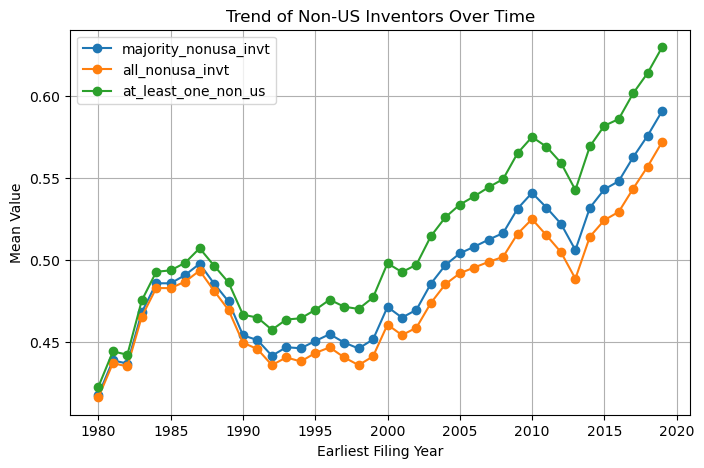

In [24]:
# Group by earliest_filing_year and calculate mean
agg_df_plot = agg_df.groupby("earliest_filing_year")[
    ["majority_nonusa_invt", "all_nonusa_invt", "at_least_one_non_us"]
].mean()

agg_df_plot =  agg_df_plot[(agg_df_plot.index >= 1980)&(agg_df_plot.index <= 2019)]
# Plot the trends
plt.figure(figsize=(8, 5))
for column in agg_df_plot.columns:
    plt.plot(agg_df_plot.index, agg_df_plot[column], marker='o', label=column)

plt.xlabel("Earliest Filing Year")
plt.ylabel("Mean Value")
plt.title("Trend of Non-US Inventors Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
#Save Pat Pub Citation Pair File
filename_save =os.path.join(ABF,"new_indicator_all\\patent_invt_indicator.csv")
print(filename_save)

agg_df.to_csv(filename_save,index=False)

C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research\Data\new_indicator_all\patent_invt_indicator.csv
